In [ ]:
!conda install -c conda-forge prophet -y

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::bleach==5.0.1=pyhd8ed1ab_0
  - conda-forge/noarch::pytest==7.2.0=pyhd8ed1ab_2
  - conda-forge/noarch::python-lsp-jsonrpc==1.0.0=pyhd8ed1ab_0
  - conda-forge/noarch::qtpy==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::sip==6.7.5=py310hd8f1fbe_0
  - conda-forge/noarch::tqdm==4.64.1=pyhd8ed1ab_0
  - conda-forge/linux-64::watchdog==2.2.1=py310hff52083_0
  - conda-forge/noarch::dask-core==2022.11.0=pyhd8ed1ab_0
  - conda-forge/noarch::flask==2.2.2=pyhd8ed1ab_0
  - conda-forge/noarch::importlib_metadata==6.0.0=hd8ed1ab_0
  - conda-forge/noarch::nltk==3.8.1=pyhd8ed1ab_0
  - conda-forge/linux-64::pyqt5-sip==12.11.0=py310hd8f1fbe_2
  - conda-forge/noarch::python-lsp-server-base==1.7.0=pyhd8ed1ab_0
  - conda-forge/noarch::pytoolconfig==1.2.4=pyhd8ed1ab_1
  - conda-forge/noarch::qdarkstyle==3.0.3=pyhd8ed1ab_0
  - conda-forge

In [1]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np
import sys
import time
from prophet import Prophet

ModuleNotFoundError: No module named 'prophet'

In [ ]:
region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
holidays_key = 'holidays_events.csv'
oil_key = 'oil.csv'

holiday = 's3://{}/{}/{}'.format(bucket, prefix, holidays_key)
oil = 's3://{}/{}/{}'.format(bucket, prefix, oil_key)

holidays = pd.read_csv(holiday)
oils = pd.read_csv(oil)


holidays

In [ ]:
df = pd.concat([oils, holidays])

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df['month'] = pd.DatetimeIndex(df.index).month
df['year'] = pd.DatetimeIndex(df.index).year
df['day'] = pd.DatetimeIndex(df.index).day

df

In [ ]:
oil_nans = df[df['dcoilwtico'].isna()]

oil_nans_by_month = df[df['dcoilwtico'].isna()]['month']
months_with_oil_nan = oil_nans_by_month.unique()

average_oil_by_month = []

for i in months_with_oil_nan:
    month_vals = df[df['month'] == i]
    total_oil = month_vals['dcoilwtico'].sum()
    average = round((total_oil/len(month_vals)), 2)
    average_oil_by_month.append((i, average))

for i in range(len(months_with_oil_nan)):
    df = df.copy()
    df.loc[(df['month'] == average_oil_by_month[i][0]) & (df['dcoilwtico'].isna()), 'dcoilwtico'] = average_oil_by_month[i][1]
    
df

In [ ]:
oil_by_month = df.groupby('type')['dcoilwtico'].count()

plt.figure(figsize=(15,4))
sns.countplot(data=df, x='type')
plt.title('Oil by type')
df

In [ ]:
oil_by_day = df.groupby('day')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_day.index, y=oil_by_day)
plt.title('Oil by day')

In [ ]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['day'].unique(), y=oil_by_day)
plt.title('Oil by day')

In [ ]:
oil_by_month = df.groupby('month')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_month.index, y=oil_by_month)
plt.title('Oil by month')

In [ ]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['month'].unique(), y=oil_by_month)
plt.title('Oil by month')

In [ ]:
oil_per_year = df.groupby(['year','month'])['dcoilwtico'].sum()

oil_per_year = pd.DataFrame(oil_per_year)
oil_per_year = oil_per_year.reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_year, x=oil_per_year['month'], y=oil_per_year['dcoilwtico'],hue=oil_per_year['year'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by year')
df

In [ ]:
oil_per_day = df.groupby(['month','day'])['dcoilwtico'].sum()

oil_per_day = pd.DataFrame(oil_per_day)
oil_per_day = oil_per_day.reset_index()


plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_day, x=oil_per_day['day'], y=oil_per_day['dcoilwtico'],hue=oil_per_day['month'], palette='husl')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by day')

In [ ]:
types_mode = df['type'].value_counts().idxmax()
locale_mode = df['locale'].value_counts().idxmax()
locale_name_mode = df['locale_name'].value_counts().idxmax()
description_mode = df['description'].value_counts().idxmax()
transferred_mode = df['transferred'].value_counts().idxmax()

df.loc[df['type'].isna(), 'type'] = types_mode
df.loc[df['locale'].isna(), 'locale'] = locale_mode
df.loc[df['locale_name'].isna(), 'locale_name'] = locale_name_mode
df.loc[df['description'].isna(), 'description'] = description_mode
df.loc[df['transferred'].isna(), 'transferred'] = transferred_mode

df

In [ ]:
type_by_month_count = df.groupby(['month', 'type'])['dcoilwtico'].sum()
type_by_month_count = type_by_month_count.reset_index()

plt.figure(figsize=(15,4))
sns.barplot(data=type_by_month_count, x=type_by_month_count['month'], y=type_by_month_count['dcoilwtico'], hue=type_by_month_count['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Type by month')

In [ ]:
types = pd.get_dummies(df['type'])
locale = pd.get_dummies(df['locale'])
locale_name = pd.get_dummies(df['locale_name'])
transferred = pd.get_dummies(df['transferred'], drop_first=True)

df = pd.concat([df, types], axis=1)
df = pd.concat([df, locale], axis=1)
df = pd.concat([df, locale_name], axis=1)
df = pd.concat([df, transferred], axis=1)

df = df.drop(['type', 'locale', 'locale_name', 'description', 'transferred','day'], axis=1)
df.head(500)

In [ ]:
df[True] = df[True].astype('uint8')
df.columns = df.columns.map(str)

In [ ]:
train = df.loc[df.index < '2017-06-23']
test = df.loc[df.index >= '2017-06-23'].drop('dcoilwtico', axis=1)
test_y = df.loc[df.index >= '2017-06-23']['dcoilwtico']


train = pd.DataFrame(train)
train = train.reset_index()
test = test.reset_index()
train = train.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})
test_x = test.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})

train.to_csv("train.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

bucket = sagemaker.Session().default_bucket()

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
bucket

In [3]:
model = Prophet()

columns = train.columns.drop(['y', 'ds'])
    
for i in columns:
    model.add_regressor(str(i))

model.fit(train)

NameError: name 'Prophet' is not defined

In [2]:
forecast_before = model.predict(test_x)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast_beforec['true'] = test_y['dcoilwtico']

forecast_beforec[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']]

NameError: name 'model' is not defined

In [23]:
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.2, 0.6, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 5.0, 0.02, 0.05, 0.03],
    'seasonality_mode' : ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='1482 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])
    print(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1]

0.16479350690598704


11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:49 - cmdstanpy - INFO - Chain [1] start processing
11:53:49 - cmdstanpy - INFO - Chain [1]

0.2096013604993099


11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] start processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:52 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] done processing
11:53:53 - cmdstanpy - INFO - Chain [1] start processing
11:53:53 - cmdstanpy - INFO - Chain [1]

0.2043532953805357


11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing
11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1] done processing
11:53:58 - cmdstanpy - INFO - Chain [1] done processing
11:53:58 - cmdstanpy - INFO - Chain [1] start processing
11:53:58 - cmdstanpy - INFO - Chain [1]

0.23572777392166036


11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1]

0.21426437896582018


11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing
11:54:06 - cmdstanpy - INFO - Chain [1] done processing
11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] done processing
11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1]

0.24244083286222304


11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] start processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:11 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] done processing
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
11:54:12 - cmdstanpy - INFO - Chain [1]

0.22633533289323918


11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing
11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1]

0.2460117092478812


11:54:20 - cmdstanpy - INFO - Chain [1] done processing
11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:20 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing
11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing
11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] 

0.19897542360469953


11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] done processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing
11:54:27 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing
11:54:27 - cmdstanpy - INFO - Chain [1] done processing
11:54:27 - cmdstanpy - INFO - Chain [1] start processing
11:54:27 - cmdstanpy - INFO - Chain [1]

0.22844362498522774


11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] done processing
11:54:31 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1]

0.2140542221847546


11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
11:54:37 - cmdstanpy - INFO - Chain [1] start processing
11:54:37 - cmdstanpy - INFO - Chain [1]

0.23359270715979583


11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1]

0.21766904139578955


11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] done processing
11:54:46 - cmdstanpy - INFO - Chain [1] start processing
11:54:46 - cmdstanpy - INFO - Chain [1]

0.23459368695342608


11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1]

0.16126408565537118


11:54:54 - cmdstanpy - INFO - Chain [1] done processing
11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] 

0.2179374754586599


11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:00 - cmdstanpy - INFO - Chain [1] start processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:00 - cmdstanpy - INFO - Chain [1] done processing
11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing
11:55:01 - cmdstanpy - INFO - Chain [1] done processing
11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:01 - cmdstanpy - INFO - Chain [1]

0.2480241671126656


11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] done processing
11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing
11:55:07 - cmdstanpy - INFO - Chain [1] 

0.2465756141407533


11:55:11 - cmdstanpy - INFO - Chain [1] done processing
11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing
11:55:11 - cmdstanpy - INFO - Chain [1] done processing
11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:11 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] start processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:12 - cmdstanpy - INFO - Chain [1] done processing
11:55:13 - cmdstanpy - INFO - Chain [1] 

0.25346759149210407


11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] 

0.2502235722929486


11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] 

0.25358927623018573


11:55:29 - cmdstanpy - INFO - Chain [1] done processing
11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:29 - cmdstanpy - INFO - Chain [1] done processing
11:55:29 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:31 - cmdstanpy - INFO - Chain [1] 

0.24902064870476912


11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:37 - cmdstanpy - INFO - Chain [1] 

0.2533442626396894


11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] 

0.24983937662996308


11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] 

0.25373025306240216


11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] 

0.24871432627812765


11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1]

0.2501772623182582


11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] 

0.2496211944088678


11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] 

0.250880730408678


11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] 

0.249912568893302


11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing
11:56:29 - cmdstanpy - INFO - Chain [1] 

0.2500547743511369


11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:34 - cmdstanpy - INFO - Chain [1] done processing
11:56:34 - cmdstanpy - INFO - Chain [1] done processing
11:56:34 - cmdstanpy - INFO - Chain [1] start processing
11:56:34 - cmdstanpy - INFO - Chain [1] start processing
11:56:34 - cmdstanpy - INFO - Chain [1] done processing
11:56:34 - cmdstanpy - INFO - Chain [1] done processing
11:56:34 - cmdstanpy - INFO - Chain [1] start processing
11:56:34 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
11:56:35 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] start processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
11:56:35 - cmdstanpy - INFO - Chain [1] done processing
11:56:35 - cmdstanpy - INFO - Chain [1] 

0.24952254821410225


11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:41 - cmdstanpy - INFO - Chain [1] done processing
11:56:41 - cmdstanpy - INFO - Chain [1] start processing
11:56:41 - cmdstanpy - INFO - Chain [1] start processing
11:56:41 - cmdstanpy - INFO - Chain [1] done processing
11:56:41 - cmdstanpy - INFO - Chain [1] start processing
11:56:41 - cmdstanpy - INFO - Chain [1]

0.11944113651394202


11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1]

0.13424787127293555


11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:57 - cmdstanpy - INFO - Chain [1] 

0.13664440905670214


11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] 

0.15313774344125244


11:57:10 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] 

0.1364265898479279


11:57:19 - cmdstanpy - INFO - Chain [1] done processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] done processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing
11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing
11:57:20 - cmdstanpy - INFO - Chain [1] start processing
11:57:20 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1]

0.1546221394489779


11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] 

0.1372277269846741


11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing
11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] start processing
11:57:37 - cmdstanpy - INFO - Chain [1] done processing
11:57:38 - cmdstanpy - INFO - Chain [1] done processing
11:57:38 - cmdstanpy - INFO - Chain [1] 

0.15427576344260474


11:57:43 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] 

0.13737206559871903


11:57:52 - cmdstanpy - INFO - Chain [1] done processing
11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:52 - cmdstanpy - INFO - Chain [1] done processing
11:57:52 - cmdstanpy - INFO - Chain [1] done processing
11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:52 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:54 - cmdstanpy - INFO - Chain [1] done processing
11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:54 - cmdstanpy - INFO - Chain [1] done processing
11:57:54 - cmdstanpy - INFO - Chain [1] start processing
11:57:54 - cmdstanpy - INFO - Chain [1]

0.15478936807931015


11:58:00 - cmdstanpy - INFO - Chain [1] done processing
11:58:00 - cmdstanpy - INFO - Chain [1] start processing
11:58:00 - cmdstanpy - INFO - Chain [1] start processing
11:58:01 - cmdstanpy - INFO - Chain [1] done processing
11:58:01 - cmdstanpy - INFO - Chain [1] done processing
11:58:01 - cmdstanpy - INFO - Chain [1] start processing
11:58:01 - cmdstanpy - INFO - Chain [1] start processing
11:58:01 - cmdstanpy - INFO - Chain [1] done processing
11:58:01 - cmdstanpy - INFO - Chain [1] done processing
11:58:01 - cmdstanpy - INFO - Chain [1] start processing
11:58:01 - cmdstanpy - INFO - Chain [1] start processing
11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:02 - cmdstanpy - INFO - Chain [1] start processing
11:58:02 - cmdstanpy - INFO - Chain [1] start processing
11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:02 - cmdstanpy - INFO - Chain [1] done processing
11:58:03 - cmdstanpy - INFO - Chain [1] 

0.12827446334701714


11:58:08 - cmdstanpy - INFO - Chain [1] done processing
11:58:08 - cmdstanpy - INFO - Chain [1] start processing
11:58:08 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing
11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] done processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing
11:58:10 - cmdstanpy - INFO - Chain [1] start processing
11:58:11 - cmdstanpy - INFO - Chain [1]

0.1467579472068418


11:58:17 - cmdstanpy - INFO - Chain [1] done processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:17 - cmdstanpy - INFO - Chain [1] done processing
11:58:17 - cmdstanpy - INFO - Chain [1] done processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] 

0.13500027380631388


11:58:25 - cmdstanpy - INFO - Chain [1] done processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:25 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing
11:58:27 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] start processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing
11:58:27 - cmdstanpy - INFO - Chain [1] done processing
11:58:27 - cmdstanpy - INFO - Chain [1] 

0.1515491487178889


11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] done processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:34 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] done processing
11:58:35 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] 

0.13234469630055173


11:58:41 - cmdstanpy - INFO - Chain [1] done processing
11:58:41 - cmdstanpy - INFO - Chain [1] start processing
11:58:41 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing
11:58:43 - cmdstanpy - INFO - Chain [1] 

0.15085899119708798


11:58:49 - cmdstanpy - INFO - Chain [1] done processing
11:58:49 - cmdstanpy - INFO - Chain [1] start processing
11:58:49 - cmdstanpy - INFO - Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
11:58:51 - cmdstanpy - INFO - Chain [1] start processing
11:58:51 - cmdstanpy - INFO - Chain [1] done processing
11:58:51 - cmdstanpy - INFO - Chain [1] done processing
11:58:51 - cmdstanpy - INFO - Chain [1] start processing
11:58:51 - cmdstanpy - INFO - Chain [1] start processing
11:58:52 - cmdstanpy - INFO - Chain [1] done processing
11:58:52 - cmdstanpy - INFO - Chain [1] done processing
11:58:52 - cmdstanpy - INFO - Chain [1] 

0.11594265760439426


11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:59 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:00 - cmdstanpy - INFO - Chain [1] done processing
11:59:00 - cmdstanpy - INFO - Chain [1] done processing
11:59:00 - cmdstanpy - INFO - Chain [1] start processing
11:59:00 - cmdstanpy - INFO - Chain [1] start processing
11:59:01 - cmdstanpy - INFO - Chain [1] done processing
11:59:01 - cmdstanpy - INFO - Chain [1] start processing
11:59:01 - cmdstanpy - INFO - Chain [1] done processing
11:59:01 - cmdstanpy - INFO - Chain [1] done processing
11:59:02 - cmdstanpy - INFO - Chain [1] start processing
11:59:02 - cmdstanpy - INFO - Chain [1] start processing
11:59:02 - cmdstanpy - INFO - Chain [1]

0.12783986417149742


11:59:11 - cmdstanpy - INFO - Chain [1] done processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing
11:59:12 - cmdstanpy - INFO - Chain [1] done processing
11:59:12 - cmdstanpy - INFO - Chain [1] done processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing
11:59:12 - cmdstanpy - INFO - Chain [1] start processing
11:59:12 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing
11:59:13 - cmdstanpy - INFO - Chain [1] start processing
11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] done processing
11:59:14 - cmdstanpy - INFO - Chain [1] 

0.13368267489274363


11:59:20 - cmdstanpy - INFO - Chain [1] done processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:22 - cmdstanpy - INFO - Chain [1] done processing
11:59:22 - cmdstanpy - INFO - Chain [1] done processing
11:59:22 - cmdstanpy - INFO - Chain [1] start processing
11:59:22 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing
11:59:23 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing
11:59:24 - cmdstanpy - INFO - Chain [1] 

0.15189739345927064


11:59:30 - cmdstanpy - INFO - Chain [1] done processing
11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:31 - cmdstanpy - INFO - Chain [1] done processing
11:59:31 - cmdstanpy - INFO - Chain [1] done processing
11:59:31 - cmdstanpy - INFO - Chain [1] start processing
11:59:31 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:33 - cmdstanpy - INFO - Chain [1] 

0.13416064030655997


11:59:39 - cmdstanpy - INFO - Chain [1] done processing
11:59:40 - cmdstanpy - INFO - Chain [1] start processing
11:59:40 - cmdstanpy - INFO - Chain [1] start processing
11:59:40 - cmdstanpy - INFO - Chain [1] done processing
11:59:40 - cmdstanpy - INFO - Chain [1] done processing
11:59:40 - cmdstanpy - INFO - Chain [1] start processing
11:59:40 - cmdstanpy - INFO - Chain [1] start processing
11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:41 - cmdstanpy - INFO - Chain [1] start processing
11:59:41 - cmdstanpy - INFO - Chain [1] start processing
11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] 

0.15208884600652217


11:59:49 - cmdstanpy - INFO - Chain [1] done processing
11:59:49 - cmdstanpy - INFO - Chain [1] start processing
11:59:49 - cmdstanpy - INFO - Chain [1] start processing
11:59:50 - cmdstanpy - INFO - Chain [1] done processing
11:59:50 - cmdstanpy - INFO - Chain [1] done processing
11:59:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:50 - cmdstanpy - INFO - Chain [1] done processing
11:59:50 - cmdstanpy - INFO - Chain [1] done processing
11:59:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:51 - cmdstanpy - INFO - Chain [1] done processing
11:59:51 - cmdstanpy - INFO - Chain [1] done processing
11:59:51 - cmdstanpy - INFO - Chain [1] start processing
11:59:51 - cmdstanpy - INFO - Chain [1] start processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing
11:59:52 - cmdstanpy - INFO - Chain [1] done processing
11:59:52 - cmdstanpy - INFO - Chain [1] 

0.1341171617402222


11:59:58 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing
12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:01 - cmdstanpy - INFO - Chain [1] done processing
12:00:01 - cmdstanpy - INFO - Chain [1] done processing
12:00:01 - cmdstanpy - INFO - Chain [1] start processing
12:00:01 - cmdstanpy - INFO - Chain [1] start processing
12:00:02 - cmdstanpy - INFO - Chain [1]

0.15109418723537127


12:00:09 - cmdstanpy - INFO - Chain [1] done processing
12:00:09 - cmdstanpy - INFO - Chain [1] start processing
12:00:09 - cmdstanpy - INFO - Chain [1] start processing
12:00:10 - cmdstanpy - INFO - Chain [1] done processing
12:00:10 - cmdstanpy - INFO - Chain [1] done processing
12:00:10 - cmdstanpy - INFO - Chain [1] start processing
12:00:10 - cmdstanpy - INFO - Chain [1] start processing
12:00:10 - cmdstanpy - INFO - Chain [1] done processing
12:00:10 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:12 - cmdstanpy - INFO - Chain [1] done processing
12:00:12 - cmdstanpy - INFO - Chain [1] done processing
12:00:12 - cmdstanpy - INFO - Chain [1] 

0.13387565416226113


12:00:18 - cmdstanpy - INFO - Chain [1] done processing
12:00:18 - cmdstanpy - INFO - Chain [1] start processing
12:00:18 - cmdstanpy - INFO - Chain [1] start processing
12:00:18 - cmdstanpy - INFO - Chain [1] done processing
12:00:19 - cmdstanpy - INFO - Chain [1] done processing
12:00:19 - cmdstanpy - INFO - Chain [1] start processing
12:00:19 - cmdstanpy - INFO - Chain [1] start processing
12:00:19 - cmdstanpy - INFO - Chain [1] done processing
12:00:19 - cmdstanpy - INFO - Chain [1] start processing
12:00:19 - cmdstanpy - INFO - Chain [1] done processing
12:00:20 - cmdstanpy - INFO - Chain [1] start processing
12:00:20 - cmdstanpy - INFO - Chain [1] done processing
12:00:20 - cmdstanpy - INFO - Chain [1] done processing
12:00:20 - cmdstanpy - INFO - Chain [1] start processing
12:00:20 - cmdstanpy - INFO - Chain [1] start processing
12:00:21 - cmdstanpy - INFO - Chain [1] done processing
12:00:21 - cmdstanpy - INFO - Chain [1] done processing
12:00:21 - cmdstanpy - INFO - Chain [1] 

0.1512935874687158


12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:29 - cmdstanpy - INFO - Chain [1] done processing
12:00:29 - cmdstanpy - INFO - Chain [1] done processing
12:00:29 - cmdstanpy - INFO - Chain [1] start processing
12:00:29 - cmdstanpy - INFO - Chain [1] start processing
12:00:29 - cmdstanpy - INFO - Chain [1] done processing
12:00:29 - cmdstanpy - INFO - Chain [1] done processing
12:00:29 - cmdstanpy - INFO - Chain [1] start processing
12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:30 - cmdstanpy - INFO - Chain [1] done processing
12:00:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:30 - cmdstanpy - INFO - Chain [1]

0.12506358551725794


12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing
12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing
12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] 

0.14184090338042313


12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1]

0.132552111104267


12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:59 - cmdstanpy - INFO - Chain [1] 

0.14899002909915857


12:01:05 - cmdstanpy - INFO - Chain [1] done processing
12:01:05 - cmdstanpy - INFO - Chain [1] start processing
12:01:05 - cmdstanpy - INFO - Chain [1] start processing
12:01:05 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:08 - cmdstanpy - INFO - Chain [1]

0.12938368463203134


12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] 

0.14782794453517106


12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:25 - cmdstanpy - INFO - Chain [1] start processing
12:01:25 - cmdstanpy - INFO - Chain [1] start processing
12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:25 - cmdstanpy - INFO - Chain [1] start processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing
12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing
12:01:27 - cmdstanpy - INFO - Chain [1] done processing
12:01:27 - cmdstanpy - INFO - Chain [1] done processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing
12:01:28 - cmdstanpy - INFO - Chain [1] done processing
12:01:28 - cmdstanpy - INFO - Chain [1] done processing
12:01:28 - cmdstanpy - INFO - Chain [1] 

0.12016944036576915


12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:38 - cmdstanpy - INFO - Chain [1] start processing
12:01:38 - cmdstanpy - INFO - Chain [1] start processing
12:01:39 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - INFO - Chain [1] 

0.12488537732933333


12:01:48 - cmdstanpy - INFO - Chain [1] done processing
12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] 

0.12881675576012033


12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] 

0.13998973288169292


12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] 

0.13028047627543074


12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] 

0.14198896509434233


12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] 

0.1303474624086545


12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1]

0.14127193426541812


12:02:58 - cmdstanpy - INFO - Chain [1] done processing
12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] 

0.13038652192684486


12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] 

0.1412105491250826


12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] 

0.1239193960847273


12:03:33 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:33 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1]

0.13251107027991027


12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1]

0.1284136576170583


12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing
12:03:55 - cmdstanpy - INFO - Chain [1] start processing
12:03:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] 

0.13984564485731157


12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:08 - cmdstanpy - INFO - Chain [1] done processing
12:04:08 - cmdstanpy - INFO - Chain [1] start processing
12:04:08 - cmdstanpy - INFO - Chain [1] start processing
12:04:08 - cmdstanpy - INFO - Chain [1] done processing
12:04:08 - cmdstanpy - INFO - Chain [1] done processing
12:04:08 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing
12:04:09 - cmdstanpy - INFO - Chain [1] 

0.12680402439363708


12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:21 - cmdstanpy - INFO - Chain [1] done processing
12:04:21 - cmdstanpy - INFO - Chain [1] 

0.13788717865333844


12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:31 - cmdstanpy - INFO - Chain [1] done processing
12:04:31 - cmdstanpy - INFO - Chain [1] done processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing
12:04:31 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] 

0.11901613786850776


12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1]

0.12492882786102368


12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing
12:04:52 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing
12:04:53 - cmdstanpy - INFO - Chain [1] done processing
12:04:53 - cmdstanpy - INFO - Chain [1] done processing
12:04:53 - cmdstanpy - INFO - Chain [1] start processing
12:04:53 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] 

0.12919387506245222


12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] done processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing
12:05:06 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] 

0.14219120849159414


12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1]

0.13025000780763848


12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] 

0.14230062477680697


12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] 

0.13107113963354317


12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing
12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing
12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:53 - cmdstanpy - INFO - Chain [1]

0.14305287913763154


12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:03 - cmdstanpy - INFO - Chain [1] 

0.13068291911686455


12:06:11 - cmdstanpy - INFO - Chain [1] done processing
12:06:11 - cmdstanpy - INFO - Chain [1] start processing
12:06:11 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] 

0.14330787048764834


12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] 

0.1238548580270384


12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1]

0.13380337489958424


12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1]

0.12881720276011854


12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1]

0.14059771665493342


12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:04 - cmdstanpy - INFO - Chain [1] start processing
12:07:04 - cmdstanpy - INFO - Chain [1] start processing
12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] 

0.1271452654667535


12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1]

0.13829077018691704
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01   multiplicative   
1                     0.001                     0.01         additive   
2                     0.001                     0.10   multiplicative   
3                     0.001                     0.10         additive   
4                     0.001                     1.00   multiplicative   
..                      ...                      ...              ...   
91                    0.500                     0.02         additive   
92                    0.500                     0.05   multiplicative   
93                    0.500                     0.05         additive   
94                    0.500                     0.03   multiplicative   
95                    0.500                     0.03         additive   

        mape  
0   0.164794  
1   0.209601  
2   0.204353  
3   0.235728  
4   0.214264  
..       ... 

In [79]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [80]:
model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=0.01, seasonality_mode='multiplicative')
model.fit(train)

12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
forecast = model.predict(test_x)
forecast [['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-06-23,50.037853,33.313500,66.377497
1,2017-06-23,50.037853,33.274224,67.879282
2,2017-06-25,43.656453,26.295476,59.288141
3,2017-06-25,43.656453,28.481130,60.419489
4,2017-06-25,43.656453,25.279132,58.870031
...,...,...,...,...
81,2017-12-22,43.849430,27.114797,62.026010
82,2017-12-23,38.066619,20.149051,53.947300
83,2017-12-24,37.802816,19.918563,54.800075
84,2017-12-25,43.215535,27.365094,59.942232


In [82]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test_y, forecast['yhat'])
mae = mean_absolute_error(test_y, forecast['yhat'])

print('MAPE is ', mape)
print('MAE is ', mae)
test_y = test_y.reset_index()
forecast['true'] = test_y['dcoilwtico']
forecast [['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']].head(50)

MAPE is  0.1298702990813369
MAE is  5.383943058684925


,ds,yhat,true,yhat_lower,yhat_upper
0,2017-06-23,50.037853,42.86,33.313500,66.377497
1,2017-06-23,50.037853,43.24,33.274224,67.879282
2,2017-06-25,43.656453,44.25,26.295476,59.288141
3,2017-06-25,43.656453,44.74,28.481130,60.419489
4,2017-06-25,43.656453,44.88,25.279132,58.870031
5,2017-06-26,48.416042,46.02,32.065878,64.390503
6,2017-06-27,49.283204,50.89,32.993270,66.097487
7,2017-06-28,48.948091,50.89,30.757356,64.493778
8,2017-06-29,49.120403,45.11,32.338634,65.815947
9,2017-06-30,49.187141,45.52,32.730165,65.323673


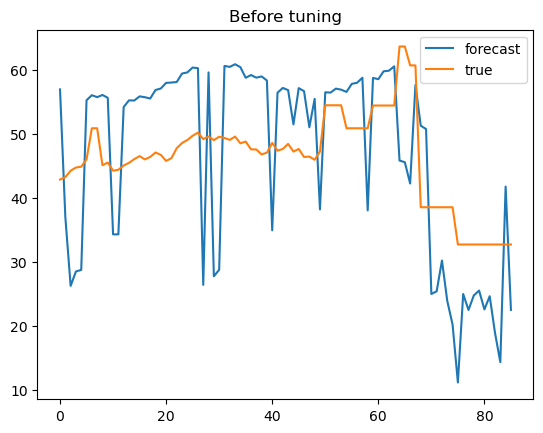

In [88]:
plt.plot(forecast_before['yhat'], label='forecast')
plt.plot(test_y['dcoilwtico'], label='true')
plt.legend()
plt.title('Before tuning')
plt.show()

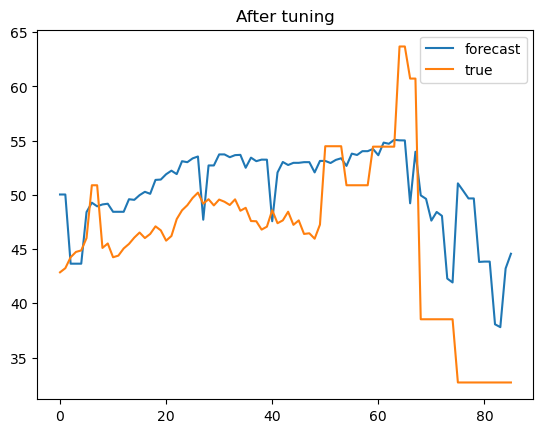

In [89]:
plt.plot(forecast['yhat'], label='forecast')
plt.plot(test_y['dcoilwtico'], label='true')
plt.legend()
plt.title('After tuning')
plt.show()